In [1]:
import pyabc
import fitmulticell as fmc
import scipy as sp
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("bmh")

ERROR:External:Install rpy2 to enable simple support for the R language.


### __Set these before proceeding__

In [10]:
# Specify XML path
CELL_POLARITY_XML = "../_models/CellPolarity.xml"
# Specify morpheus executable path
MORPHEUS_BIN = "/Applications/Morpheus.app/Contents/MacOS/bin/morpheus"
# Specify database path
CELL_POLARITY_DB = "sqlite:///../_db/cell_polarity.db"
CELL_POLARITY_STOCHASTIC_DB = "sqlite:///../_db/cell_polarity_stochastic.db"

In [11]:
# Create parameter mapping
par_map = {
    "r_a": "./CellTypes/CellType[@name='Cell']/System/Constant[@symbol='r_a']",
    "p_a": "./CellTypes/CellType[@name='Cell']/System/Constant[@symbol='b_a']"
}
# Create model instance
model = fmc.model.MorpheusModel(
    CELL_POLARITY_XML,
    par_map=par_map,
    executable=MORPHEUS_BIN,
    show_stdout=False,
    show_stderr=True,
    raise_on_error=False
)

### True parameters

In [12]:
# True parameters
true_pars = {
    "r_a": 0.02,
    "p_a": 0.1
}
# Bounds for true parameters
true_pars_limits = {
    "r_a": (0.5 * 0.02, 2.0 * 0.02),
    "p_a": (0.5 * 0.1, 2.0 * 0.1)
}

### Sample data using true parameters

In [13]:
# Generate dummy observed data sampled from true parameters
observed_data = model.sample(true_pars)

### Simulation plot

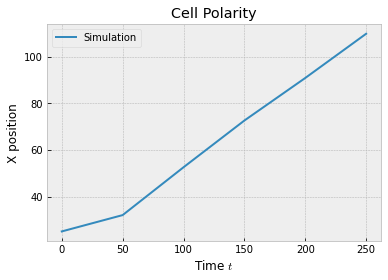

In [14]:
plt.plot(
    observed_data["IdSumstat__t"],
    observed_data["IdSumstat__center_cell1"],
    color="C0",
    label="Simulation"
)
plt.xlabel("Time $t$")
plt.ylabel("X position")
plt.title("Cell Polarity")
plt.legend()
plt.show()

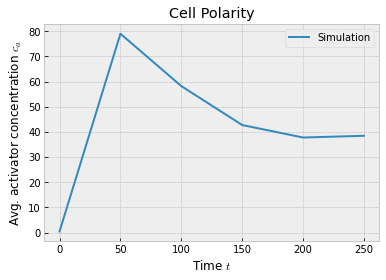

In [15]:
plt.plot(
    observed_data["IdSumstat__t"],
    observed_data["IdSumstat__mean_c_a"],
    color="C0",
    label="Simulation",
)
plt.xlabel("Time $t$")
plt.ylabel("Avg. activator concentration $c_a$")
plt.title("Cell Polarity")
plt.legend()
plt.show()

### Parameter inference (using uniform acceptor)

In [16]:
def sumstat(data):
    # Take the last position from the x position array
    return {'x_pos': data['IdSumstat__center_cell1'][-1]}

def dist(data, simulation):
    # Calculate the distance between the x positions
    return np.absolute(data["x_pos"] - simulation["x_pos"])

In [19]:
# Set prior for parameters
priors = pyabc.Distribution(
    **{key: pyabc.RV("uniform", lb, ub - lb) for key, (lb, ub) in true_pars_limits.items()}
)
# Obtain ABCSMC instance
cell_polarity_abc_uniform = pyabc.ABCSMC(
    models=model,
    parameter_priors=priors,
    distance_function=dist,
    summary_statistics=sumstat,
    population_size=50,
    sampler=pyabc.sampler.SingleCoreSampler()
)
# cell_polarity_abc.new(CELL_POLARITY_DB, cell_polarity_observed_data)
cell_polarity_abc_uniform.new(CELL_POLARITY_DB, {'x_pos': 200}) # x position: 200 is the end of the domain
# cell_polarity_abc_uniform.load(CELL_POLARITY_DB, 17)

INFO:History:Start <ABCSMC(id=21, start_time=2020-07-07 00:00:14.114164, end_time=None)>


In [20]:
history_uniform = cell_polarity_abc_uniform.run(minimum_epsilon=0.2, max_nr_populations=3)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 88.12982104999999
INFO:ABC:t: 0, eps: 88.12982104999999.
INFO:ABC:Acceptance rate: 50 / 110 = 4.5455e-01, ESS=5.0000e+01.
INFO:ABC:t: 1, eps: 84.65157175.
INFO:ABC:Acceptance rate: 50 / 244 = 2.0492e-01, ESS=3.8640e+01.
INFO:ABC:t: 2, eps: 82.67471245326365.
INFO:ABC:Acceptance rate: 50 / 447 = 1.1186e-01, ESS=3.7849e+01.
INFO:History:Done <ABCSMC(id=21, start_time=2020-07-07 00:00:14.114164, end_time=2020-07-07 00:03:40.357454)>


### Epsilon vs. Population (for uniform acceptor)

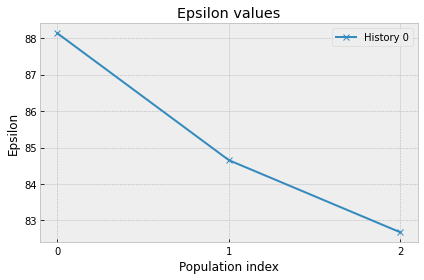

In [21]:
pyabc.visualization.plot_epsilons(history_uniform)
plt.show()

### KDE Matrix (for uniform acceptor)

In [ ]:
pyabc.visualization.plot_kde_matrix_highlevel(
    history_uniform,
    limits=true_pars_limits,
    refval=true_pars
)
plt.show()

### $r_a$ and $p_a$ posterior development (for uniform acceptor)

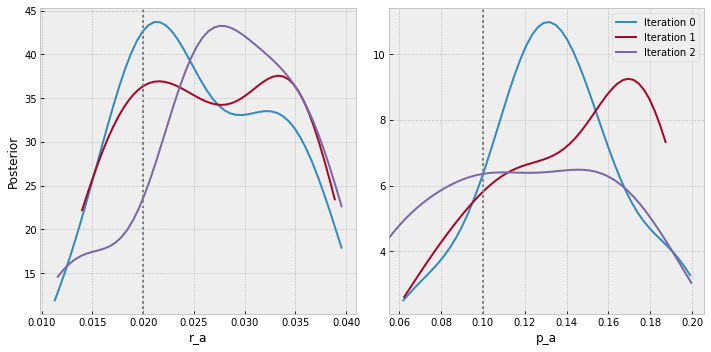

In [25]:
fig, ax = plt.subplots(1,2)
for t in range(history_uniform.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_uniform, x="r_a", t=t,
        refval=true_pars, refval_color='grey',
        ax=ax[0], label=f"Iteration {t}")
    pyabc.visualization.plot_kde_1d_highlevel(
        history_uniform, x="p_a", t=t,
        refval=true_pars, refval_color='grey',
        ax=ax[1], label=f"Iteration {t}")
ax[1].set_xlabel("p_a")
ax[1].set_ylabel(None)
ax[1].legend()
fig.set_size_inches((10, 5))
fig.tight_layout()
plt.show()

### 2D KDE (for uniform acceptor)

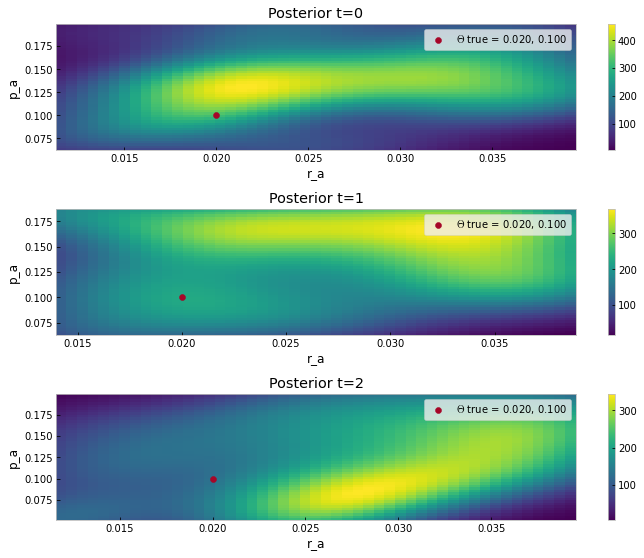

In [26]:
fig = plt.figure(figsize=(10,10))
for t in range(history_uniform.max_t+1):
    ax = fig.add_subplot(4, np.ceil(history_uniform.max_t / 3), t+1)

    ax = pyabc.visualization.plot_kde_2d_highlevel(
        history_uniform, x="r_a", y="p_a", t=t, ax=ax
    )
    ax.scatter([true_pars["r_a"]], [true_pars["p_a"]], color="C1",
                label='$\Theta$ true = {:.3f}, {:.3f}'.format(
                    true_pars["r_a"], true_pars["p_a"]))
    ax.set_title("Posterior t={}".format(t))

    ax.legend()
fig.tight_layout()

### Parameter inference (using stochastic acceptor)

In [27]:
# Set prior for parameters
priors = pyabc.Distribution(
    **{key: pyabc.RV("uniform", lb, ub - lb) for key, (lb, ub) in true_pars_limits.items()}
)
# Obtain ABCSMC instance
cell_polarity_abc_stochastic = pyabc.ABCSMC(
    models=model,
    parameter_priors=priors,
    summary_statistics=sumstat,
    population_size=50,
    sampler=pyabc.sampler.SingleCoreSampler(),
    distance_function=pyabc.IndependentNormalKernel(keys=["x_pos"], var=0.5**2),
    eps=pyabc.Temperature(),
    acceptor=pyabc.StochasticAcceptor()
)
cell_polarity_abc_stochastic.new(CELL_POLARITY_STOCHASTIC_DB, {'x_pos': 200}) # x position: 200 is the end of the domain
# cell_polarity_abc_stochastic.load(CELL_POLARITY_STOCHASTIC_DB, 2)

INFO:History:Start <ABCSMC(id=3, start_time=2020-07-07 00:05:03.375929, end_time=None)>


In [ ]:
history_stochastic = cell_polarity_abc_stochastic.run(minimum_epsilon=0.2, max_nr_populations=3)

INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 2627.7233198599433.
INFO:ABC:Acceptance rate: 50 / 202 = 2.4752e-01, ESS=4.9983e+01.
INFO:ABC:t: 1, eps: 51.2613238207905.


### Epsilon vs. Population (for stochastic acceptor)

In [ ]:
pyabc.visualization.plot_epsilons(history_stochastic)
plt.show()

### KDE Matrix (for stochastic acceptor)

In [ ]:
pyabc.visualization.plot_kde_matrix_highlevel(
    history_stochastic,
    limits=true_pars_limits,
    efval=cell_polarity_true_pars)
plt.show()

### $r_a$ and $p_a$ posterior development (for stochastic acceptor)

In [ ]:
fig, ax = plt.subplots(1,2)
for t in range(history_stochastic.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_stochastic, x="r_a", t=t,
        refval=true_pars, refval_color='grey',
        ax=ax[0], label=f"Iteration {t}")
    pyabc.visualization.plot_kde_1d_highlevel(
        history_stochastic, x="p_a", t=t,
        refval=true_pars, refval_color='grey',
        ax=ax[1], label=f"Iteration {t}")
ax[1].set_xlabel("p_a")
ax[1].set_ylabel(None)
ax[1].legend()
fig.set_size_inches((10, 5))
fig.tight_layout()
plt.show()

### 2D KDE (for stochastic acceptor)

In [ ]:
fig = plt.figure(figsize=(10,10))
for t in range(history_stochastic.max_t+1):
    ax = fig.add_subplot(4, np.ceil(history_stochastic.max_t / 3), t+1)

    ax = pyabc.visualization.plot_kde_2d_highlevel(
        history_stochastic, x="r_a", y="p_a", t=t, ax=ax
    )
    ax.scatter([cell_polarity_true_pars["r_a"]], [cell_polarity_true_pars["p_a"]], color="C1",
                label='$\Theta$ true = {:.3f}, {:.3f}'.format(
                    cell_polarity_true_pars["r_a"], cell_polarity_true_pars["p_a"]))
    ax.set_title("Posterior t={}".format(t))

    ax.legend()
fig.tight_layout()

In [ ]:
df,old = cell_polarity_abc_history.get_distribution(m=0,t=5)
dis = cell_polarity_abc_history.get_weighted_distances(t=5)
daa = pd.concat([df.set_index(np.arange(len(df))),dis],axis=1)
daa.head(20)